# Подбор лучших моделей 

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as mp
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

Подготовка данных

In [2]:
train_df = pd.read_csv('../data/train_preprocessed.csv')
test_df = pd.read_csv('../data/test_preprocessed.csv')

X_train = train_df.drop('Churn', axis=1)
y_train = train_df['Churn']
X_test = test_df.drop('Churn', axis=1)
y_test = test_df['Churn']

scaler = StandardScaler()

pipeline = mp(
    scaler,
    SMOTE(random_state=42)
)

X_train_processed, y_train_processed = pipeline.fit_resample(X_train, y_train)

X_test_processed = scaler.transform(X_test)

Сравнение моделей без кросс-валидации

In [3]:
models = {
    'Logistic Regression' : LogisticRegression(random_state=42),
    'Random Forest' : RandomForestClassifier(random_state=42),
    'Gradient Boosting' : GradientBoostingClassifier(random_state=42),
    'SVC' : SVC(random_state=42, probability=True),
    'CatBoost' : CatBoostClassifier(random_state=42),
    'XGBoost' : XGBClassifier(random_state=42, eval_metric='logloss')
}

In [4]:
results_no_cv = {}

for name, model in models.items():
    model.fit(X_train_processed, y_train_processed)

    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    results_no_cv[name] = {
        'accuracy' : accuracy,
        'roc_auc' : roc_auc,
        'f1' : f1,
        'recall' : recall
    }

Learning rate set to 0.025403
0:	learn: 0.6804822	total: 146ms	remaining: 2m 26s
1:	learn: 0.6681874	total: 151ms	remaining: 1m 15s
2:	learn: 0.6574978	total: 157ms	remaining: 52s
3:	learn: 0.6474703	total: 161ms	remaining: 40.1s
4:	learn: 0.6373765	total: 165ms	remaining: 32.9s
5:	learn: 0.6273978	total: 170ms	remaining: 28.2s
6:	learn: 0.6168896	total: 175ms	remaining: 24.8s
7:	learn: 0.6082478	total: 179ms	remaining: 22.2s
8:	learn: 0.5998700	total: 184ms	remaining: 20.2s
9:	learn: 0.5900641	total: 188ms	remaining: 18.6s
10:	learn: 0.5817790	total: 193ms	remaining: 17.3s
11:	learn: 0.5738922	total: 198ms	remaining: 16.3s
12:	learn: 0.5676230	total: 202ms	remaining: 15.3s
13:	learn: 0.5609121	total: 207ms	remaining: 14.6s
14:	learn: 0.5552585	total: 211ms	remaining: 13.9s
15:	learn: 0.5499705	total: 216ms	remaining: 13.3s
16:	learn: 0.5442877	total: 221ms	remaining: 12.8s
17:	learn: 0.5381562	total: 226ms	remaining: 12.3s
18:	learn: 0.5315685	total: 230ms	remaining: 11.9s
19:	learn: 

Сравнение метрик качества

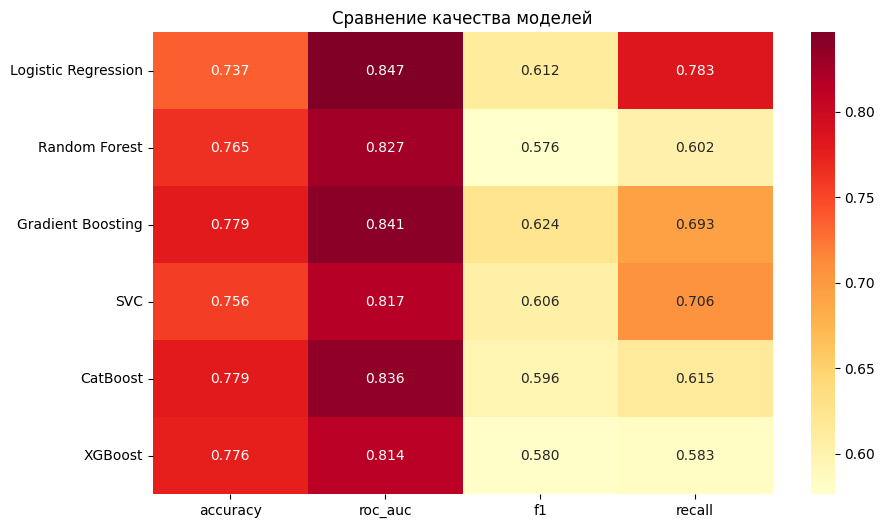

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

comp_df = pd.DataFrame(results_no_cv).T

plt.figure(figsize=(10, 6))
sns.heatmap(comp_df, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Сравнение качества моделей')
plt.show()

Сравнение моделей с кросс-валидацией

In [6]:
scores = ['accuracy', 'roc_auc', 'f1', 'recall']

results_cv_mean = {}
results_cv_std = {}

for name, model in models.items():
    cv_scores = cross_validate(
        model,
        X_train_processed,
        y_train_processed,
        cv=5,
        scoring=scores,
        n_jobs=-1,
        return_train_score=False
    )

    results_cv_mean[name] = {}
    results_cv_std[name] = {}
    for score_name in scores:
        key = f'test_{score_name}'
        results_cv_mean[name][score_name] = cv_scores[key].mean()
        results_cv_std[name][score_name] = cv_scores[key].std()

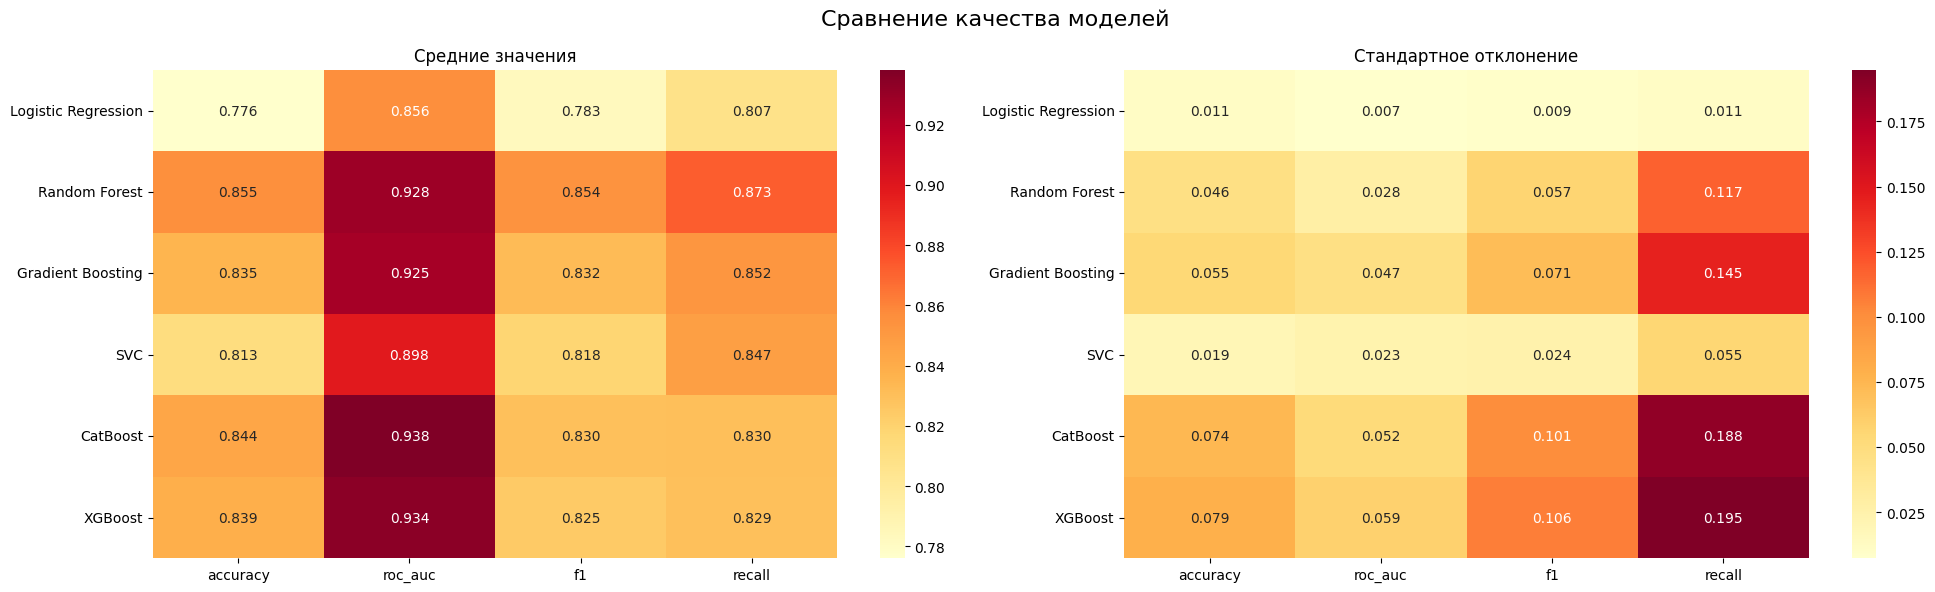

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

comp_df_mean = pd.DataFrame(results_cv_mean).T
comp_df_std = pd.DataFrame(results_cv_std).T

_, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.heatmap(comp_df_mean, annot=True, cmap='YlOrRd', fmt='.3f', ax=axes[0])
axes[0].set_title('Средние значения')

sns.heatmap(comp_df_std, annot=True, cmap='YlOrRd', fmt='.3f', ax=axes[1])
axes[1].set_title('Стандартное отклонение')

plt.suptitle('Сравнение качества моделей', fontsize=16)
plt.tight_layout()
plt.show()

### Исходя из сравнение моделей по метрикам качества, выберем 3: Random Forest, CatBoost, XGBoost